In [28]:
import pandas as pd

artists = pd.read_csv('dataset/remapped/artists.csv')
tags = pd.read_csv('dataset/remapped/tags.csv')
user_artists = pd.read_csv('dataset/remapped/user_artists.csv')
user_tags = pd.read_csv('dataset/remapped/user_tags.csv')

In [29]:
import numpy as np
from scipy.sparse import csr_matrix

# Assuming user_tags, tags, and artists DataFrames are already loaded

# Get the distribution of tags for each artist
artist_tag_distribution = (
    user_tags.groupby(['artistID', 'tagID'])
    .size()
    .unstack(fill_value=0)  # Converts to wide format with tagIDs as columns
)
artist_tag_distribution.columns.name = None  # Remove column name for clarity
artist_tag_distribution.reset_index(inplace=True)  # Make artistID a regular column

artist_tag_distribution.shape



(12133, 9719)

In [30]:

# Build bag-of-words embeddings
# Merge `user_tags` with `tags` to get the tag values
user_tags_with_values = user_tags.merge(tags, how='left', left_on='tagID', right_on='tagID')

# Combine all tag values for each artist
artist_bow = user_tags_with_values.groupby('artistID')['tagValue'].apply(
    lambda x: ' '.join(map(str, x))
).reset_index()


artist_bow.head()

,artistID,tagValue
0,0,weeabo jrock j-rock visual kei better than lad...
1,1,german seen live darkwave industrial german ge...
2,2,black metal black metal norwegian black metal ...
3,3,j-rock visual kei metal gothic japanese bazaro...
4,4,gothic gothic rock darkwave darkwave deathrock...


In [31]:

# Vectorize using CountVectorizer to build bag-of-words embeddings
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(artist_bow['tagValue'])

embedding_dim = len(vectorizer.get_feature_names_out())
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 7592


In [32]:
# Create a DataFrame with bag-of-words embeddings
artist_embeddings = pd.DataFrame.sparse.from_spmatrix(
    bow_matrix, columns=vectorizer.get_feature_names_out(), index=artist_bow['artistID']
)

artist_embeddings.shape


(12133, 7592)

In [33]:
# Normalize rows in the embedding matrix
artist_embeddings = artist_embeddings.div(artist_embeddings.sum(axis=0), axis=1)

In [34]:
# Build a sparse matrix of shape (artist_count, embedding_dim)
# Ensure all artists have rows in the sparse matrix
all_artists = artists[['id']].rename(columns={'id': 'artistID'})
artist_embeddings_full = all_artists.merge(artist_embeddings, how='left', on='artistID').fillna(0)

# Convert to sparse matrix
embedding_sparse_matrix = csr_matrix(artist_embeddings_full.drop(columns=['artistID']).values)

# Output results
print("Tag distribution by artist:")
print(artist_tag_distribution)

print("\nBag-of-Words Embeddings for artists:")
print(artist_embeddings)

print("\nSparse matrix shape (artist_count x embedding_dim):", embedding_sparse_matrix.shape)


Tag distribution by artist:
       artistID  0  1  2  3  4  5  6  7  8  ...  11935  11936  11937  11938  \
0             0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
1             1  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
2             2  0  0  0  3  0  0  0  0  0  ...      0      0      0      0   
3             3  2  0  0  0  0  0  1  0  0  ...      0      0      0      0   
4             4  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
...         ... .. .. .. .. .. .. .. .. ..  ...    ...    ...    ...    ...   
12128     17623  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
12129     17625  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
12130     17626  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
12131     17627  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   
12132     17630  0  0  0  0  0  0  0  0  0  ...      0      0      0      0   

       11939  11940  11

In [35]:
def get_artist_name(artist_id):
    return artists.loc[artists['id'] == artist_id, 'name'].values[0]

In [36]:
from scipy.sparse import coo_matrix

# Create a sparse matrix for user-artist interactions
user_artist_matrix = coo_matrix(
    (user_artists['weight'], (user_artists['userID'], user_artists['artistID']))
)

# Output the shape of the matrix
print(f"Sparse matrix shape: {user_artist_matrix.shape}")

item_features = csr_matrix(embedding_sparse_matrix)



Sparse matrix shape: (1892, 17632)


In [37]:
from lightfm.data import Dataset

# Initialize the Dataset object
dataset = Dataset(user_identity_features=False, item_identity_features=False)

# Fit the dataset with users and items
# Specify the number of users and items based on the user_artist_matrix
num_users, num_artists = user_artist_matrix.shape
dataset.fit(
    range(num_users),  # User IDs
    range(num_artists)  # Artist IDs
)

# Build interactions and weights matrices
(interactions, weights) = dataset.build_interactions(
    [(row['userID'], row['artistID'], row['weight']) for _, row in user_artists.iterrows()]
)

# Output the shape of the interactions matrix
print(f"Interactions matrix shape: {interactions.shape}")

Interactions matrix shape: (1892, 17632)


In [38]:
seed = 42

from lightfm.cross_validation import random_train_test_split

# Split the interactions into training and testing datasets
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=seed)
trainweighted, testweighted = random_train_test_split(weights, test_percentage=0.2, random_state=seed)

# Output the number of interactions in train and test
print(f"Training interactions: {train.getnnz()}")
print(f"Testing interactions: {test.getnnz()}")

Training interactions: 74267
Testing interactions: 18567


In [36]:
from lightfm import LightFM
from lightfm.evaluation import auc_score

# Train a model to check sanity
model = LightFM(loss='warp')
model.fit(train, epochs=10, num_threads=4,item_features=item_features,verbose=True)
auc_score(model, test, train_interactions=train,item_features=item_features).mean()


Epoch:  20%|██        | 2/10 [00:08<00:34,  4.35s/it]


KeyboardInterrupt: 

In [37]:
%pip install optuna
import optuna

def objective(trial):
    seed = 123
    tr, val = random_train_test_split(train, test_percentage=0.2, random_state=seed)


    param = {
        'no_components': trial.suggest_int("no_components", 5, 64),
        "learning_schedule": trial.suggest_categorical("learning_schedule", ["adagrad"]),
        "loss":  trial.suggest_categorical("loss", ["bpr", "warp", "warp-kos"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1),
        "item_alpha": trial.suggest_float("item_alpha", 1e-10, 1e-06, log=True),
        "user_alpha": trial.suggest_float("user_alpha", 1e-10, 1e-06, log=True), 
    }
    epochs = trial.suggest_int("epochs", 20, 50)

    model = LightFM(**param, random_state=seed)

    model.fit(tr,epochs=epochs, num_threads=4, item_features=item_features,verbose=True)

    print('Evaluating AUC')
    val_auc = auc_score(model, val, train_interactions=tr, num_threads=4, item_features=item_features).mean()

    return val_auc

study = optuna.create_study(direction="maximize")

Defaulting to user installation because normal site-packages is not writeable


[I 2024-12-15 19:23:22,557] A new study created in memory with name: no-name-e3700133-5041-4c0a-8a77-bb8447e567b9


Note: you may need to restart the kernel to use updated packages.


In [38]:
study.optimize(objective, n_trials=20)

best_params = study.best_params

# Save the best parameters to a file
with open('best_params.txt', 'w') as f:
    f.write(str(best_params))

for k,v in best_params.items():
    print(f"{k}: {v}")

Epoch:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 100%|██████████| 36/36 [05:55<00:00,  9.86s/it]


Evaluating AUC


[I 2024-12-15 19:31:52,920] Trial 0 finished with value: 0.5123187303543091 and parameters: {'no_components': 47, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.5269557899307902, 'item_alpha': 2.2478318878272398e-07, 'user_alpha': 9.973266264677835e-07, 'epochs': 36}. Best is trial 0 with value: 0.5123187303543091.
Epoch: 100%|██████████| 27/27 [04:29<00:00, 10.00s/it]


Evaluating AUC


[I 2024-12-15 19:39:03,009] Trial 1 finished with value: 0.4993444085121155 and parameters: {'no_components': 47, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.8416278086589835, 'item_alpha': 1.743956556331243e-07, 'user_alpha': 5.54876351830769e-10, 'epochs': 27}. Best is trial 0 with value: 0.5123187303543091.
Epoch: 100%|██████████| 38/38 [03:57<00:00,  6.25s/it]


Evaluating AUC


[I 2024-12-15 19:45:37,217] Trial 2 finished with value: 0.5434648990631104 and parameters: {'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.15064884672411447, 'item_alpha': 2.9651213522308017e-09, 'user_alpha': 3.652724441143773e-10, 'epochs': 38}. Best is trial 2 with value: 0.5434648990631104.
Epoch: 100%|██████████| 29/29 [12:36<00:00, 26.08s/it]


Evaluating AUC


[I 2024-12-15 20:00:48,205] Trial 3 finished with value: 0.6597545146942139 and parameters: {'no_components': 53, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.08552487702995491, 'item_alpha': 3.5327455460482625e-08, 'user_alpha': 2.8303901561212053e-07, 'epochs': 29}. Best is trial 3 with value: 0.6597545146942139.
Epoch: 100%|██████████| 22/22 [01:01<00:00,  2.81s/it]


Evaluating AUC


[I 2024-12-15 20:04:03,114] Trial 4 finished with value: 0.5018500089645386 and parameters: {'no_components': 12, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.8782963728800627, 'item_alpha': 2.030332577990992e-07, 'user_alpha': 9.5082872590387e-10, 'epochs': 22}. Best is trial 3 with value: 0.6597545146942139.
Epoch: 100%|██████████| 25/25 [00:52<00:00,  2.12s/it]


Evaluating AUC


[I 2024-12-15 20:07:04,742] Trial 5 finished with value: 0.49926549196243286 and parameters: {'no_components': 9, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.7274136061900485, 'item_alpha': 3.3991808330506276e-09, 'user_alpha': 1.4191756379788426e-09, 'epochs': 25}. Best is trial 3 with value: 0.6597545146942139.
Epoch: 100%|██████████| 39/39 [06:19<00:00,  9.72s/it]


Evaluating AUC


[I 2024-12-15 20:15:58,396] Trial 6 finished with value: 0.4921845495700836 and parameters: {'no_components': 60, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.8967530113832768, 'item_alpha': 1.5238745444759913e-10, 'user_alpha': 4.482543828621837e-10, 'epochs': 39}. Best is trial 3 with value: 0.6597545146942139.
Epoch: 100%|██████████| 49/49 [04:25<00:00,  5.41s/it]


Evaluating AUC


[I 2024-12-15 20:22:48,723] Trial 7 finished with value: 0.5002003312110901 and parameters: {'no_components': 26, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.5012870724672603, 'item_alpha': 8.55692830088078e-07, 'user_alpha': 3.319921921937027e-09, 'epochs': 49}. Best is trial 3 with value: 0.6597545146942139.
Epoch: 100%|██████████| 27/27 [00:36<00:00,  1.33s/it]


Evaluating AUC


[I 2024-12-15 20:25:26,449] Trial 8 finished with value: 0.49589771032333374 and parameters: {'no_components': 5, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.4859097588858361, 'item_alpha': 1.3033738644199414e-07, 'user_alpha': 4.832886213412742e-08, 'epochs': 27}. Best is trial 3 with value: 0.6597545146942139.
Epoch: 100%|██████████| 38/38 [04:00<00:00,  6.32s/it]


Evaluating AUC


[I 2024-12-15 20:31:59,043] Trial 9 finished with value: 0.5042657852172852 and parameters: {'no_components': 38, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.6849763254981361, 'item_alpha': 1.1025979617260175e-07, 'user_alpha': 8.409020219391872e-09, 'epochs': 38}. Best is trial 3 with value: 0.6597545146942139.
Epoch: 100%|██████████| 31/31 [15:07<00:00, 29.27s/it]


Evaluating AUC


[I 2024-12-15 20:49:39,230] Trial 10 finished with value: 0.6666444540023804 and parameters: {'no_components': 60, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.06742335839498442, 'item_alpha': 1.8721648349024738e-08, 'user_alpha': 1.4568104575534705e-07, 'epochs': 31}. Best is trial 10 with value: 0.6666444540023804.
Epoch: 100%|██████████| 31/31 [16:07<00:00, 31.19s/it]


Evaluating AUC


[I 2024-12-15 21:08:18,909] Trial 11 finished with value: 0.6943098306655884 and parameters: {'no_components': 64, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.013115408203141471, 'item_alpha': 1.5091914856963442e-08, 'user_alpha': 2.4557265208238066e-07, 'epochs': 31}. Best is trial 11 with value: 0.6943098306655884.
Epoch: 100%|██████████| 31/31 [15:53<00:00, 30.76s/it]


Evaluating AUC


[I 2024-12-15 21:26:44,670] Trial 12 finished with value: 0.555104672908783 and parameters: {'no_components': 64, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.24999649312817884, 'item_alpha': 1.1925711736657066e-08, 'user_alpha': 3.9660498365400616e-08, 'epochs': 31}. Best is trial 11 with value: 0.6943098306655884.
Epoch: 100%|██████████| 33/33 [15:20<00:00, 27.89s/it]


Evaluating AUC


[I 2024-12-15 21:44:37,739] Trial 13 finished with value: 0.689663827419281 and parameters: {'no_components': 57, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.01071135751925617, 'item_alpha': 5.470462006121272e-10, 'user_alpha': 1.3349842918856967e-07, 'epochs': 33}. Best is trial 11 with value: 0.6943098306655884.
Epoch: 100%|██████████| 44/44 [10:21<00:00, 14.12s/it]


Evaluating AUC


[I 2024-12-15 21:57:24,928] Trial 14 finished with value: 0.6326454281806946 and parameters: {'no_components': 28, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.29228814753088916, 'item_alpha': 4.544793568515257e-10, 'user_alpha': 9.172520647705161e-07, 'epochs': 44}. Best is trial 11 with value: 0.6943098306655884.
Epoch: 100%|██████████| 33/33 [13:56<00:00, 25.35s/it]


Evaluating AUC


[I 2024-12-15 22:13:54,592] Trial 15 finished with value: 0.546320915222168 and parameters: {'no_components': 53, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.27448802074820045, 'item_alpha': 1.3318870951459755e-09, 'user_alpha': 4.429881311554726e-08, 'epochs': 33}. Best is trial 11 with value: 0.6943098306655884.
Epoch: 100%|██████████| 20/20 [08:50<00:00, 26.50s/it]


Evaluating AUC


[I 2024-12-15 22:25:20,684] Trial 16 finished with value: 0.683260440826416 and parameters: {'no_components': 54, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.006007913692567842, 'item_alpha': 1.1476004321132497e-10, 'user_alpha': 1.9606073804811565e-07, 'epochs': 20}. Best is trial 11 with value: 0.6943098306655884.
Epoch: 100%|██████████| 42/42 [10:25<00:00, 14.89s/it]


Evaluating AUC


[I 2024-12-15 22:38:16,625] Trial 17 finished with value: 0.5958719849586487 and parameters: {'no_components': 30, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.39989218853902353, 'item_alpha': 6.222163021293326e-10, 'user_alpha': 1.1115553718525073e-10, 'epochs': 42}. Best is trial 11 with value: 0.6943098306655884.
Epoch: 100%|██████████| 34/34 [17:42<00:00, 31.24s/it]


Evaluating AUC


[I 2024-12-15 22:58:32,547] Trial 18 finished with value: 0.6027612686157227 and parameters: {'no_components': 64, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.13079880929240412, 'item_alpha': 3.735535162660529e-09, 'user_alpha': 1.517410806138472e-08, 'epochs': 34}. Best is trial 11 with value: 0.6943098306655884.
Epoch: 100%|██████████| 43/43 [16:10<00:00, 22.58s/it]


Evaluating AUC


[I 2024-12-15 23:17:20,102] Trial 19 finished with value: 0.5929297208786011 and parameters: {'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.2210249224600619, 'item_alpha': 4.1605001795778055e-08, 'user_alpha': 4.187597368079008e-07, 'epochs': 43}. Best is trial 11 with value: 0.6943098306655884.


no_components: 64
learning_schedule: adagrad
loss: bpr
learning_rate: 0.013115408203141471
item_alpha: 1.5091914856963442e-08
user_alpha: 2.4557265208238066e-07
epochs: 31


In [39]:
optuna.importance.get_param_importances(study)

{'learning_rate': 0.5170781761781031,
 'loss': 0.3590724350853819,
 'epochs': 0.060940014112745744,
 'user_alpha': 0.05164747507947809,
 'no_components': 0.010938851034558966,
 'item_alpha': 0.0003230485097321638,
 'learning_schedule': 0.0}

In [13]:
from lightfm.evaluation import auc_score

def iterative_fit(model, epochs,item_features,sample_weights, train,test):
    train_scores = []
    test_scores = []

    for epoch in range(epochs):
        model.fit_partial(train, item_features=item_features, sample_weight=sample_weights, num_threads=4, verbose=True)

        train_auc = auc_score(model, train, item_features=item_features, num_threads=4).mean()
        test_auc = auc_score(model, test, train_interactions=train, item_features=item_features, num_threads=4).mean()

        print(f'Epoch {epoch} Train AUC: {train_auc:.2f}, Test AUC: {test_auc:.2f}')
        train_scores.append(train_auc)
        test_scores.append(test_auc)
        print(f"Epoch {epoch} completed")

    return model, train_scores, test_scores

In [14]:
from lightfm import LightFM
model = LightFM(loss='bpr',no_components=4, random_state=123, learning_rate=0.01, item_alpha=1e-06, user_alpha=1e-06, learning_schedule='adagrad')

model, train_scores, test_scores = iterative_fit(model, 2, item_features,trainweighted, train, test)


Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


Epoch 0 Train AUC: 0.52, Test AUC: 0.50
Epoch 0 completed


Epoch: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


Epoch 1 Train AUC: 0.52, Test AUC: 0.50
Epoch 1 completed


In [22]:
# Plot the training and testing scores
import matplotlib.pyplot as plt
def plot_scores(train_scores, test_scores, image_name):

    plt.plot(train_scores, label='Train AUC')
    plt.plot(test_scores, label='Test AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.savefig(image_name)
    plt.show()

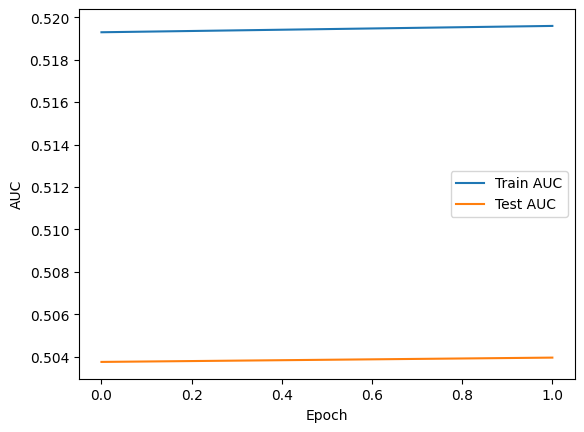

In [23]:
plot_scores(train_scores, test_scores, 'img/train_test_scores-test00.png')

In [19]:
import pickle 
def save_model(model, filename):
    # Pickles the model
    with open(filename, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

save_model(model, 'lightfm_model_test.pkl')

In [32]:
# Tidy up epochs as not a parameter to be passed to LightFM() directly
# num_epochs = best_params['epochs'] # save best epochs as a separate object
# del best_params['epochs'] # then remove it from best_params object

# Train with the best parameters
# model = LightFM(**best_params, random_state=123)
from lightfm import LightFM


model = LightFM(loss='bpr',no_components=64, random_state=123, learning_rate=0.01, item_alpha=1e-06, user_alpha=1e-06, learning_schedule='adagrad')
model.fit(train, 
          item_features=item_features,
          epochs = 30,
          verbose=True)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 100%|██████████| 30/30 [1:14:57<00:00, 149.92s/it]


In [34]:
# Evaluate the trained model
train_auc = auc_score(model, train, item_features=item_features).mean()
test_auc = auc_score(model, test, item_features=item_features).mean()

print(f"Train AUC: {train_auc:.2f}")
print(f"Test AUC: {test_auc:.2f}")

Train AUC: 0.75
Test AUC: 0.71


In [35]:
# build a model without features
model_no_features = LightFM(loss='bpr',no_components=64, random_state=123, learning_rate=0.01, item_alpha=1e-06, user_alpha=1e-06, learning_schedule='adagrad')
model_no_features.fit(train, epochs=30, verbose=True)

# Evaluate the model without features
train_auc_no_features = auc_score(model_no_features, train).mean()
test_auc_no_features = auc_score(model_no_features, test).mean()

print(f"Train AUC (no features): {train_auc_no_features:.2f}")
print(f"Test AUC (no features): {test_auc_no_features:.2f}")

Epoch: 100%|██████████| 30/30 [02:07<00:00,  4.24s/it]


Train AUC (no features): 0.79
Test AUC (no features): 0.75


In [36]:
# Model with weights
model_weighted = LightFM(loss='warp',no_components=64, random_state=123, learning_rate=0.01, item_alpha=1e-06, user_alpha=1e-06, learning_schedule='adagrad')
model_weighted.fit(train, epochs=30, item_features=item_features, sample_weight=trainweighted, verbose=True)

# Evaluate the model with weights
train_auc_weighted = auc_score(model_weighted, train, item_features=item_features).mean()
test_auc_weighted = auc_score(model_weighted, test, item_features=item_features).mean()

print(f"Train AUC (weighted): {train_auc_weighted:.2f}")
print(f"Test AUC (weighted): {test_auc_weighted:.2f}")


Epoch: 100%|██████████| 30/30 [14:20<00:00, 28.70s/it]


Train AUC (weighted): 0.88
Test AUC (weighted): 0.86


In [38]:
%pip install pickle
import pickle

with open('final_model.pkl', 'wb') as f:
    pickle.dump(model_weighted, f, protocol=pickle.HIGHEST_PROTOCOL)

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
Note: you may need to restart the kernel to use updated packages.


Final model using 128 components

In [24]:
model = LightFM(loss='warp',no_components=64, random_state=123, learning_rate=0.01, item_alpha=1e-06, user_alpha=1e-06, learning_schedule='adagrad')
model.fit(train, epochs=30, item_features=item_features, sample_weight=trainweighted, verbose=True)

Epoch: 100%|██████████| 1/1 [01:14<00:00, 74.40s/it]


Epoch 0 Train AUC: 0.52, Test AUC: 0.50
Epoch 0 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.62s/it]


Epoch 1 Train AUC: 0.53, Test AUC: 0.50
Epoch 1 completed


Epoch: 100%|██████████| 1/1 [01:14<00:00, 74.25s/it]


Epoch 2 Train AUC: 0.53, Test AUC: 0.50
Epoch 2 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.46s/it]


Epoch 3 Train AUC: 0.53, Test AUC: 0.50
Epoch 3 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.30s/it]


Epoch 4 Train AUC: 0.53, Test AUC: 0.50
Epoch 4 completed


Epoch: 100%|██████████| 1/1 [01:14<00:00, 74.22s/it]


Epoch 5 Train AUC: 0.53, Test AUC: 0.50
Epoch 5 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.70s/it]


Epoch 6 Train AUC: 0.53, Test AUC: 0.50
Epoch 6 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.09s/it]


Epoch 7 Train AUC: 0.53, Test AUC: 0.50
Epoch 7 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.42s/it]


Epoch 8 Train AUC: 0.53, Test AUC: 0.50
Epoch 8 completed


Epoch: 100%|██████████| 1/1 [01:12<00:00, 72.91s/it]


Epoch 9 Train AUC: 0.53, Test AUC: 0.50
Epoch 9 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.37s/it]


Epoch 10 Train AUC: 0.53, Test AUC: 0.50
Epoch 10 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.41s/it]


Epoch 11 Train AUC: 0.53, Test AUC: 0.50
Epoch 11 completed


Epoch: 100%|██████████| 1/1 [01:12<00:00, 72.93s/it]


Epoch 12 Train AUC: 0.53, Test AUC: 0.50
Epoch 12 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.25s/it]


Epoch 13 Train AUC: 0.53, Test AUC: 0.50
Epoch 13 completed


Epoch: 100%|██████████| 1/1 [01:12<00:00, 72.88s/it]


Epoch 14 Train AUC: 0.53, Test AUC: 0.50
Epoch 14 completed


Epoch: 100%|██████████| 1/1 [01:14<00:00, 74.09s/it]


Epoch 15 Train AUC: 0.53, Test AUC: 0.50
Epoch 15 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.03s/it]


Epoch 16 Train AUC: 0.53, Test AUC: 0.50
Epoch 16 completed


Epoch: 100%|██████████| 1/1 [01:12<00:00, 72.74s/it]


Epoch 17 Train AUC: 0.53, Test AUC: 0.50
Epoch 17 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.77s/it]


Epoch 18 Train AUC: 0.53, Test AUC: 0.50
Epoch 18 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.56s/it]


Epoch 19 Train AUC: 0.53, Test AUC: 0.50
Epoch 19 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.19s/it]


Epoch 20 Train AUC: 0.53, Test AUC: 0.50
Epoch 20 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.41s/it]


Epoch 21 Train AUC: 0.53, Test AUC: 0.50
Epoch 21 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.14s/it]


Epoch 22 Train AUC: 0.53, Test AUC: 0.50
Epoch 22 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.22s/it]


Epoch 23 Train AUC: 0.53, Test AUC: 0.50
Epoch 23 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.76s/it]


Epoch 24 Train AUC: 0.53, Test AUC: 0.50
Epoch 24 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.43s/it]


Epoch 25 Train AUC: 0.53, Test AUC: 0.50
Epoch 25 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.11s/it]


Epoch 26 Train AUC: 0.53, Test AUC: 0.50
Epoch 26 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.23s/it]


Epoch 27 Train AUC: 0.53, Test AUC: 0.50
Epoch 27 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.13s/it]


Epoch 28 Train AUC: 0.53, Test AUC: 0.50
Epoch 28 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.04s/it]


Epoch 29 Train AUC: 0.53, Test AUC: 0.50
Epoch 29 completed


Epoch: 100%|██████████| 1/1 [01:13<00:00, 73.25s/it]


Epoch 30 Train AUC: 0.53, Test AUC: 0.50
Epoch 30 completed


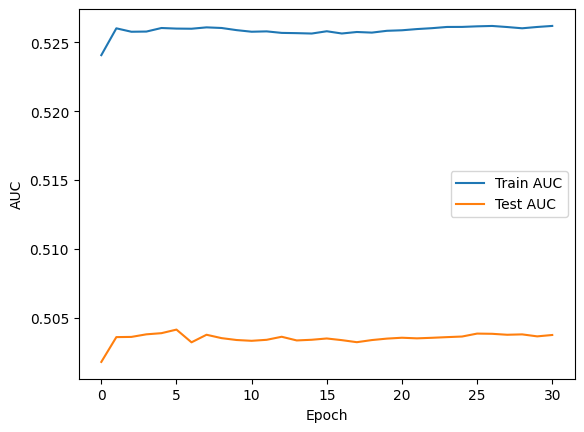

In [25]:
train_auc = auc_score(model, train, item_features=item_features).mean()
test_auc = auc_score(model, test, item_features=item_features).mean()

In [26]:
save_model(model, 'lightfm_model_128components_31epochs.pkl')

Testing the best model

In [23]:
# Load the model from pickle
import pickle
with open('final_model.pkl', 'rb') as f:
    model_loaded = pickle.load(f)

In [5]:
# Load the user_tags dataframe and merge it with the tags dataframe
user_tags_with_values = user_tags.merge(tags, how='left', left_on='tagID', right_on='tagID')
user_tags_with_values.head()

,userID,artistID,tagID,day,month,year,tagValue
0,0,46,12,1,4,2009,chillout
1,0,46,14,1,4,2009,downtempo
2,0,46,17,1,4,2009,electronic
3,0,46,20,1,4,2009,trip-hop
4,0,46,40,1,4,2009,female vovalists


In [111]:
# A function to get the tags for a user, showing only the tagValue and number of times it appears
user_to_recommend = 17
def get_user_tags(user_id):
    user_tags_values = user_tags_with_values[user_tags_with_values['userID'] == user_id]
    return user_tags_values[['tagValue', 'userID']].groupby('tagValue').count().sort_values(by='userID', ascending=False).rename(columns={'userID': 'count'})

get_user_tags(user_to_recommend)[:10]

,count
tagValue,
noize,2
crust,1
downtempo,1
drone,1
idm,1
idmbient,1
screamo,1
witch house,1


In [112]:
# Show the top 10 artists for the given user, with number of times they were listened to (merging with artist dataframe)
def get_user_artists(user_id):
    user_artists_values = user_artists[user_artists['userID'] == user_id]
    user_artists_values = user_artists_values.merge(artists, how='left', left_on='artistID', right_on='id')
    return user_artists_values[['name', 'weight']].groupby('name').sum().sort_values(by='weight', ascending=False)

get_user_artists(user_to_recommend)[:10]

,weight
name,
Aidan Baker,987
Nadja,483
Autechre,375
Aidan Baker & thisquietarmy,304
Deftones,290
Salem,285
Carbon Based Lifeforms,274
Boards of Canada,268
Casino Versus Japan,261


In [114]:
# Make recommendations for the user
def recommend_artists(user_id, model, artist_embeddings, n=10):
    # Get the user's interactions
    user_interactions = user_artist_matrix.getrow(user_id)
    # Predict scores
    scores = model.predict(user_id, np.arange(num_artists), item_features=artist_embeddings)
    # Get top artist IDs
    top_artist_ids = np.argsort(-scores)
    # Filter out artists the user has already interacted with
    top_artist_ids = [artist_id for artist_id in top_artist_ids if user_interactions[0, artist_id] == 0]
    # Get the artist names
    top_artists = [get_artist_name(artist_id) for artist_id in top_artist_ids]
    return top_artists[:n]

recommend_artists(user_to_recommend, model_loaded, item_features)

['Depeche Mode',
 'Sigur Rós',
 'Nine Inch Nails',
 'Radiohead',
 'The Cure',
 'Metallica',
 'The Beatles',
 'Muse',
 'Led Zeppelin',
 'System of a Down']